In [1]:
!pip install tensorflow

     |████████████████████████████████| 497.6 MB 10 kB/s s eta 0:00:01    |████                            | 62.7 MB 12.1 MB/s eta 0:00:37     |███████▊                        | 119.7 MB 12.0 MB/s eta 0:00:32     |████████▎                       | 128.5 MB 12.1 MB/s eta 0:00:31     |████████▉                       | 137.3 MB 12.0 MB/s eta 0:00:30     |███████████████                 | 233.6 MB 12.1 MB/s eta 0:00:22     |███████████████▊                | 244.5 MB 12.0 MB/s eta 0:00:22     |██████████████████▉             | 292.5 MB 10.5 MB/s eta 0:00:20     |██████████████████████▋         | 350.9 MB 12.1 MB/s eta 0:00:13
     |████████████████████████████████| 462 kB 13.7 MB/s eta 0:00:01     |███████████████████▉            | 286 kB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 970 kB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 13.3 MB/s eta 0:00:01
     |█████████████████████

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from copy import deepcopy
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import tensorflow as tf

from mlxtend.plotting import plot_decision_regions

from neural_network import *

%matplotlib inline

2022-05-10 19:11:02.360416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 19:11:02.360485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Atividade 1
#### Grupo: 
- Gregory Filipe Lira da Silva
- Lincoln Wallace Valentim da Costa
- Denilson Pedro

### UTILS

In [10]:
def __softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def classification_predictions(x, y, is_binary, nn=None, threshold=0.0, figsize=(12,6), s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    plt.scatter(x[:, 0], x[:, 1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    if nn is not None:
        plt.subplot(1, 2, 2, sharex=ax, sharey=ax)

        x1, x2, x_mesh = __compute_meshgrid(x, y)
        y_mesh = nn.predict(x_mesh)
        y_mesh = np.where(y_mesh <= threshold, 0, 1) if is_binary else np.argmax(__softmax(y_mesh), axis=1)

        plt.scatter(x[:, 0], x[:, 1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
        plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)

        
def make_log10(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.logspace(np.log10(x_min), np.log10(x_max), n_samples)
    y = np.log10(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)

## Estrutura das Redes

- Perceptron: por padrão ele vem com, alpha=0.0001, numero maximo de iteração: 1000, validation fraction=0.1, verbose=0
- MLPClassifier e MLPRegressor: por padrão vem a função de ativação relu, hidden layer sizes=(100,), solver adam, learning rate inicial de 0.001 e learning rate constante, batch size = auto, numero maximo de iteração de 200, momentum de 0.9.
- Keras: todas as utilizações é apresentado um sumario logo a seguir



### Questão 1

In [5]:
x = np.array([[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0],[1,1,1]])


print(x.shape)

(8, 3)


In [6]:
classes = [ i for i in range(x.shape[0])] # para organizar e colocar cada um das 8 classes
classes

[0, 1, 2, 3, 4, 5, 6, 7]

In [7]:
data = pd.DataFrame(np.column_stack((x,classes)), columns=['x1','x2','x3','class'])
data

,x1,x2,x3,class
0,0,0,0,0
1,0,0,1,1
2,0,1,0,2
3,0,1,1,3
4,1,0,0,4
5,1,0,1,5
6,1,1,0,6
7,1,1,1,7


In [8]:
def gerar_dados(quantidade, base):
    dados_gerados = deepcopy(base)
    valores = dados_gerados[['x1','x2','x3']].values
    
    for i in range(quantidade):
        ruido = np.array([np.random.uniform(-0.1,0.1) for i in range(x.shape[0]*x.shape[1])]).reshape(8,3)
        novos_valores = valores + ruido
        for k in range(len(novos_valores)):
            #adicionando novos dados no final do dataset com o ruido
            dados_gerados.loc[len(dados_gerados)] = [novos_valores[k][0],novos_valores[k][1],novos_valores[k][2],k]
            
    return dados_gerados

In [9]:
dados_novos = gerar_dados(500,data)
dados_novos

,x1,x2,x3,class
0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,1.000000,1.0
2,0.000000,1.000000,0.000000,2.0
3,0.000000,1.000000,1.000000,3.0
4,1.000000,0.000000,0.000000,4.0
...,...,...,...,...
4003,0.055694,0.950918,1.066947,3.0
4004,0.954186,-0.007930,-0.044526,4.0
4005,0.925323,-0.046716,1.041229,5.0
4006,1.086646,1.002694,-0.047613,6.0


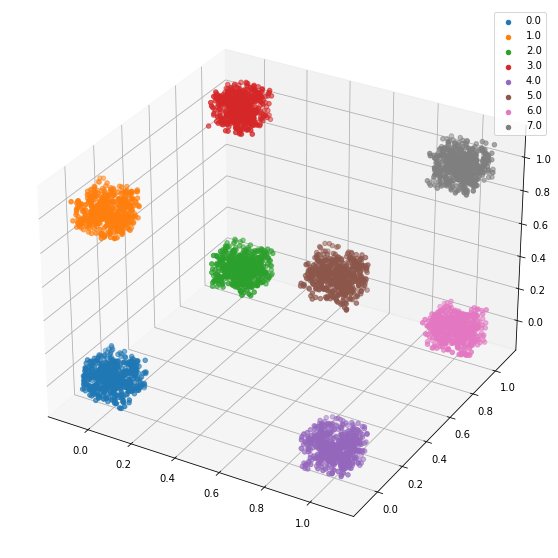

In [10]:
classes = dados_novos['class'].unique()

figure = plt.figure(figsize=(20,10))
axis = figure.add_subplot(111, projection='3d')

for classe in classes:
    valores =  dados_novos[dados_novos['class'] == classe].values
    x = valores[:,0]
    y = valores[:,1]
    z = valores[:,2]
    axis.scatter(x,y,z, label=classe)
    
axis.legend()

In [11]:
# separando dados
X = dados_novos[['x1','x2','x3']].values
y = dados_novos[['class']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train.shape, X_test.shape

((2805, 3), (1203, 3))

In [12]:
# perceptron do sklearning
model = Perceptron()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [13]:
print('Reporte: \n')
print(classification_report(y_test,y_pred))


Reporte: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       149
         1.0       1.00      1.00      1.00       148
         2.0       1.00      1.00      1.00       146
         3.0       1.00      1.00      1.00       146
         4.0       1.00      1.00      1.00       152
         5.0       1.00      1.00      1.00       163
         6.0       1.00      1.00      1.00       148
         7.0       1.00      1.00      1.00       151

    accuracy                           1.00      1203
   macro avg       1.00      1.00      1.00      1203
weighted avg       1.00      1.00      1.00      1203



In [31]:
# perceptron implementado

w = np.random.randn(8 , X.shape[1]) # [8x3] 8 caracteristica para 3 colunas de entrada
learning_rate = 1e-3

for step in range(201):
    cost = 0
    for x_n, y_n in zip(X_train,y_train):
        y_pred = np.dot(x_n,w.T)
        y_pred = np.argmax(y_pred)
        error = y_n - y_pred
        #atualizar os pesos, se ele errou, quando y_n é diferente de y_pred (por isso atualizar os pesos nas posições respectivas)
        if not (y_n == y_pred):
            w[int(y_n)] +=  learning_rate* x_n # adiciona importancia a entrada
            w[int(y_pred)] -=  learning_rate* x_n #  diminui a importancia pois errou 

        cost += error**2
    if step % 10 == 0:
        print('epoch: {0}/{1} loss_train: {2:.4f}'.format(step,200,0.5*(cost/(len(X_train)))))

print('w: ',w)


epoch: 0/200 loss_train: 3.2522
epoch: 10/200 loss_train: 0.5945
epoch: 20/200 loss_train: 0.6119
epoch: 30/200 loss_train: 0.5927
epoch: 40/200 loss_train: 0.5800
epoch: 50/200 loss_train: 0.5831
epoch: 60/200 loss_train: 0.5540
epoch: 70/200 loss_train: 0.5572
epoch: 80/200 loss_train: 0.5537
epoch: 90/200 loss_train: 0.5576
epoch: 100/200 loss_train: 0.5843
epoch: 110/200 loss_train: 0.6189
epoch: 120/200 loss_train: 0.6332
epoch: 130/200 loss_train: 0.6485
epoch: 140/200 loss_train: 0.6467
epoch: 150/200 loss_train: 0.6948
epoch: 160/200 loss_train: 0.6971
epoch: 170/200 loss_train: 0.6529
epoch: 180/200 loss_train: 0.7180
epoch: 190/200 loss_train: 0.6642
epoch: 200/200 loss_train: 0.7066
w:  [[-0.02633536  0.3993259  -0.76961589]
 [ 0.01622762  0.30696945 -0.64473632]
 [-0.02596261  0.39991628 -0.76951375]
 [-0.00270103  0.33859476 -0.65679332]
 [ 0.01902708  0.30584391 -0.64726107]
 [ 0.01830552  0.3056847  -0.6463188 ]
 [-0.00343728  0.38634937 -0.72344511]
 [ 0.00994189  0.363

In [34]:
y_pred = np.argmax( np.dot(X_test, w.T) , axis=1 )

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.16      0.28       149
         1.0       0.81      1.00      0.90       148
         2.0       0.83      1.00      0.91       146
         3.0       0.93      0.99      0.96       146
         4.0       0.88      1.00      0.94       152
         5.0       0.90      1.00      0.95       163
         6.0       0.98      1.00      0.99       148
         7.0       0.93      0.99      0.96       151

    accuracy                           0.89      1203
   macro avg       0.91      0.89      0.86      1203
weighted avg       0.91      0.89      0.86      1203



## Questão 2

### A) Porta XOR

In [2]:
def gerar_dados_xor(quantidade, base):
    dados_gerados = deepcopy(base)
    valores = dados_gerados[['x0','x1']].values
    
    for i in range(quantidade):
        ruido = np.array([np.random.uniform(-0.1,0.1) for i in range(x.shape[0]*x.shape[1])]).reshape(4,2)
        novos_valores = valores + ruido
        for k in range(len(novos_valores)):
            #adicionando novos dados no final do dataset com o ruido
            if (k == 2):
                dados_gerados.loc[len(dados_gerados)] = [novos_valores[k][0],novos_valores[k][1],1]
            elif (k == 3):
                dados_gerados.loc[len(dados_gerados)] = [novos_valores[k][0],novos_valores[k][1],0]
            else:
                dados_gerados.loc[len(dados_gerados)] = [novos_valores[k][0],novos_valores[k][1],k]
            
            
    return dados_gerados

(4, 2) (4, 1)


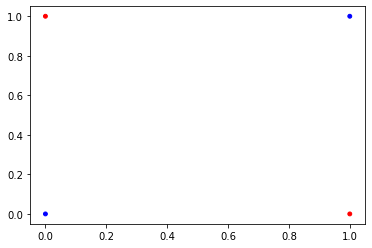

In [3]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

In [4]:
data  = pd.DataFrame(np.column_stack((x,y)), columns=["x0","x1","y"])
data

,x0,x1,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [5]:
novos_dados = gerar_dados_xor(500, data)


In [6]:
novos_dados

,x0,x1,y
0,0.000000,0.000000,0.0
1,0.000000,1.000000,1.0
2,1.000000,0.000000,1.0
3,1.000000,1.000000,0.0
4,-0.057383,-0.093957,0.0
...,...,...,...
1999,0.926231,1.068260,0.0
2000,-0.079439,-0.000923,0.0
2001,-0.018087,0.921410,1.0
2002,1.032389,-0.027359,1.0


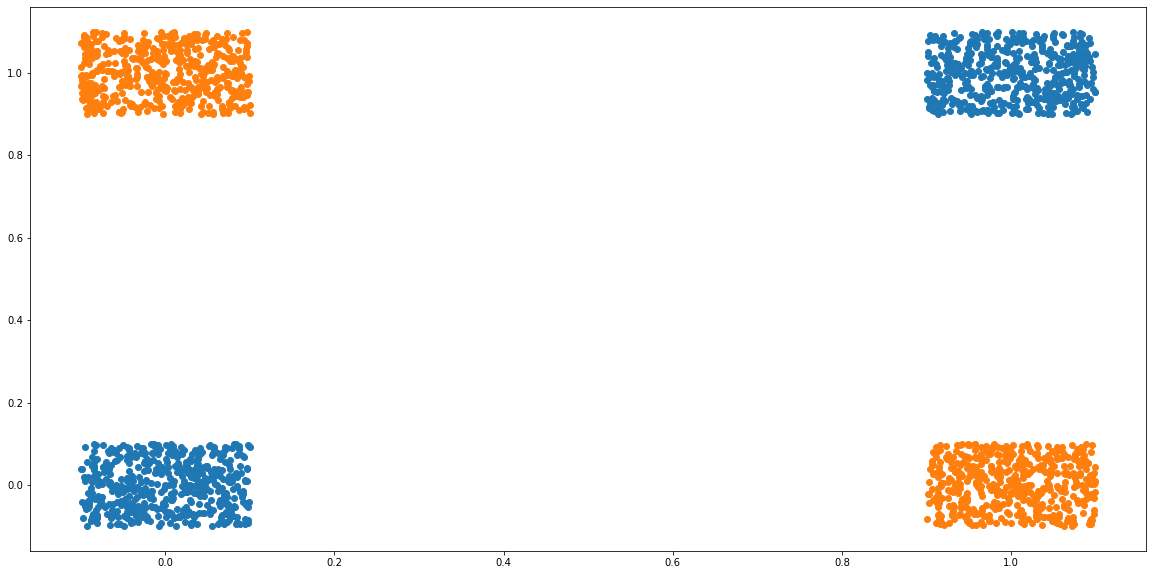

In [7]:
classes = novos_dados['y'].unique()

figure = plt.figure(figsize=(20,10))
axis = figure.add_subplot(111)

for classe in classes:
    valores =  novos_dados[novos_dados['y'] == classe].values
    x = valores[:,0]
    y = valores[:,1]
    axis.scatter(x,y, label=classe)
    


In [8]:
x = novos_dados[["x0","x1"]].values
y = novos_dados[["y"]].values
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3)

x.shape, y.shape # mostrando a quantidade de dados utilizados.

((2004, 2), (2004, 1))

#### MLPClassifier

/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Acurácia: 100.00%


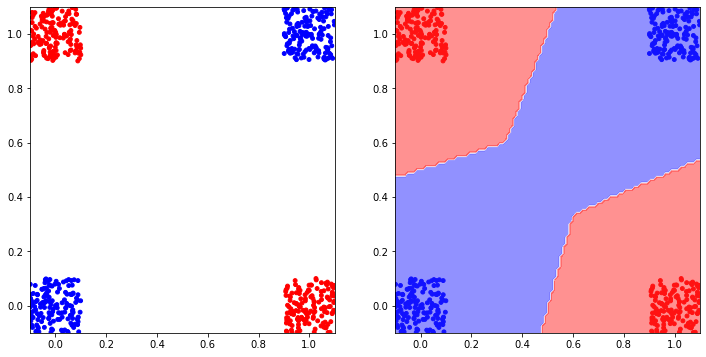

In [23]:
# Utilizando sklearn
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(activation='relu', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

classification_predictions(X_test, y_pred, is_binary=True, threshold=0.5, nn=model, cmap='bwr')

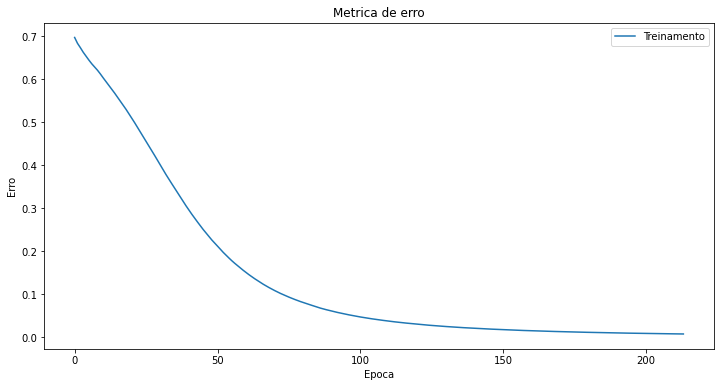

In [26]:
plt.figure(figsize=(12,6))
plt.plot(model.loss_curve_)
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()



#### Rede Implementada

epoch:    0/3000 loss_train: 0.82874304
epoch:  300/3000 loss_train: 0.59731276
epoch:  600/3000 loss_train: 0.49176693
epoch:  900/3000 loss_train: 0.37117338
epoch: 1200/3000 loss_train: 0.26361083
epoch: 1500/3000 loss_train: 0.18457485
epoch: 1800/3000 loss_train: 0.13240191
epoch: 2100/3000 loss_train: 0.09871692
epoch: 2400/3000 loss_train: 0.07647506
epoch: 2700/3000 loss_train: 0.06123622
epoch: 3000/3000 loss_train: 0.05039137
Predições:
[[0.02229736]
 [0.95216616]
 [0.95275428]
 ...
 [0.95106992]
 [0.93676578]
 [0.07283334]]
Acurácia: 100.00%


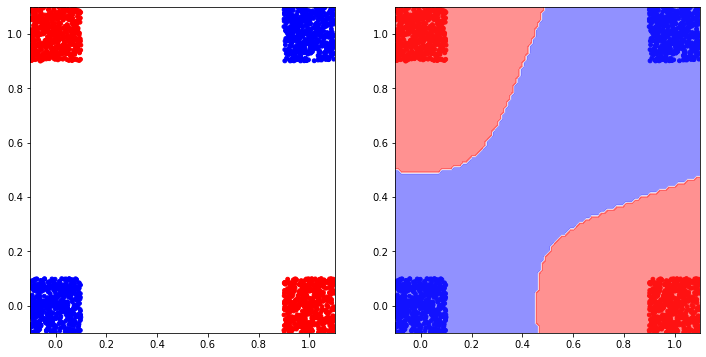

In [11]:
# Rede Neural implementada

input_dim, output_dim = X_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=sigmoid))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=sigmoid))

nn.fit(X_train,y_train, X_test, y_test,True, epochs=3000, verbose=300)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

classification_predictions(x, y, is_binary=True, threshold=0.5, nn=nn, cmap='bwr')

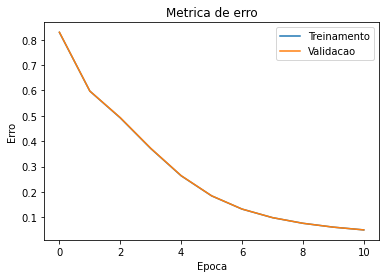

--> Acuracia (train): 1.0000
--> Acuracia (test): 1.0000


In [13]:
plt.plot(nn.train_val_loss['loss'])
plt.plot(nn.train_val_loss['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred = np.round(nn.predict(X_test))
pred_train = np.round(nn.predict(X_train))

print(f'--> Acuracia (train): {accuracy_score(y_train, pred_train):.4f}')
print(f'--> Acuracia (test): {accuracy_score(y_test, pred):.4f}')

In [14]:
nn.train_val_loss['loss']

[0.8287430422128416,
 0.5973127640971931,
 0.49176692679125483,
 0.3711733788098286,
 0.263610830723054,
 0.18457485435520274,
 0.13240190849153385,
 0.0987169180288655,
 0.07647505507863946,
 0.06123622312040282,
 0.05039137389609391]

In [15]:
nn.train_val_loss['val_loss']

[0.8293126900229777,
 0.5974361209611557,
 0.492695822389254,
 0.37207546529980356,
 0.26416827480032756,
 0.18486677665991003,
 0.13253883130974203,
 0.09876752195331974,
 0.07647737713019834,
 0.06121117952963784,
 0.05035071543838851]

### B) Log10

In [23]:
x,y = make_log10(100, 1, 10, noise=0, random_state=None)

In [24]:
# normalizar os dados
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

x.shape, y.shape # mostrando a quantidade de dados utilizados.

((100, 1), (100, 1))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3)

### Mlp Regressor

In [26]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor( max_iter=3000).fit(X_train, y_train)

/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


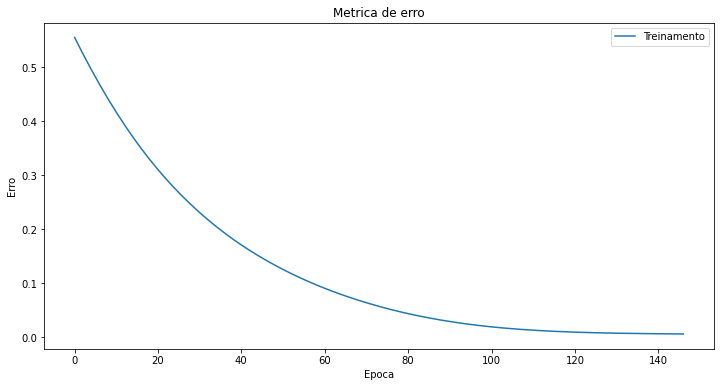

In [27]:
plt.figure(figsize=(12,6))
plt.plot(regr.loss_curve_)
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()


#### Rede Keras

In [107]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(1)))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

# Compilar o modelo
model.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 10)                20        
                                                                 
 dense_51 (Dense)            (None, 10)                110       
                                                                 
 dense_52 (Dense)            (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
3/3 [==============================] - 0s 57ms/step - loss: 0.3460 - mean_squared_error: 0.3460 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3250 - mean_squared_error: 0.3250 - val_loss: 0.2777 - val_mean_squared_error: 0.2777
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3064 - mean_squared_error: 0.3064 - val_loss: 0.2608 - val_mean_squared_error: 0.2608
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.2875 - mean_squared_error: 0.2875 - val_loss: 0.2446 - val_mean_squared_error: 0.2446
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2694 - mean_squared_error: 0.2694 - val_loss: 0.2288 - val_mean_squared_error: 0.2288
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2129 - val_mean_squared_error: 0.2129
Epoch 7/100
3/3 [=======================

Epoch 52/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 53/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 54/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 55/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 56/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 57/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 58/100
3/3 [================

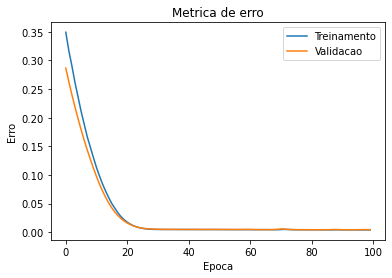

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred = np.round(model.predict(X_test))
pred_train = np.round(model.predict(X_train))


### Rede Neural Implementada

In [76]:
## Utilizando a Rede Neural Implementada
input_dim, output_dim = X_train.shape[1], y_train.shape[1]


nn = NeuralNetwork(cost_func = mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim= 10, activation = tanh))
nn.layers.append(Layer(input_dim=10, output_dim= output_dim, activation = linear))

nn.fit(X_train,y_train, X_test, y_test, True, epochs=3000, verbose= 300)


epoch:    0/3000 loss_train: 3.36093820
epoch:  300/3000 loss_train: 0.07492331
epoch:  600/3000 loss_train: 0.03502841
epoch:  900/3000 loss_train: 0.02094460
epoch: 1200/3000 loss_train: 0.01457402
epoch: 1500/3000 loss_train: 0.01124217
epoch: 1800/3000 loss_train: 0.00926417
epoch: 2100/3000 loss_train: 0.00796706
epoch: 2400/3000 loss_train: 0.00704966
epoch: 2700/3000 loss_train: 0.00636109
epoch: 3000/3000 loss_train: 0.00581883


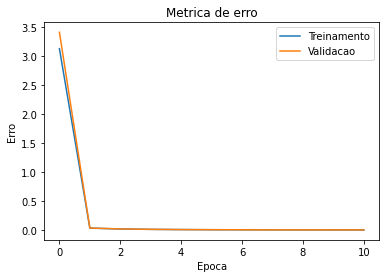

In [119]:
plt.plot(nn.train_val_loss['loss'])
plt.plot(nn.train_val_loss['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred = np.round(nn.predict(X_test))
pred_train = np.round(nn.predict(X_train))


epoch:    0/3000 loss_train: 26.48560178
epoch:  300/3000 loss_train: 0.81108246
epoch:  600/3000 loss_train: 0.28071410
epoch:  900/3000 loss_train: 0.13728868
epoch: 1200/3000 loss_train: 0.08351294
epoch: 1500/3000 loss_train: 0.05777868
epoch: 1800/3000 loss_train: 0.04317532
epoch: 2100/3000 loss_train: 0.03387782
epoch: 2400/3000 loss_train: 0.02749120
epoch: 2700/3000 loss_train: 0.02287546
epoch: 3000/3000 loss_train: 0.01941773


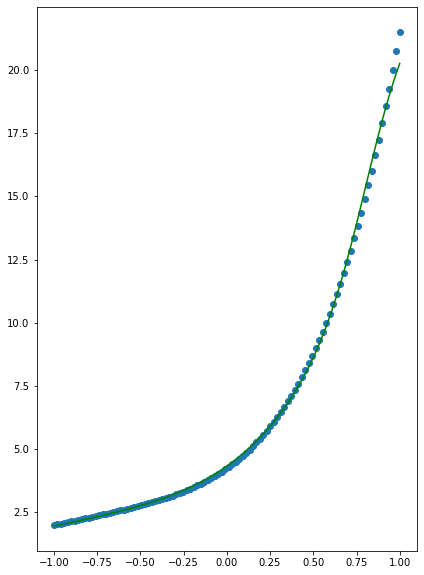

In [149]:
input_dim, output_dim = x.shape[1], y.shape[1]


nn = NeuralNetwork(cost_func = mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim= 10, activation = tanh))
nn.layers.append(Layer(input_dim=10, output_dim= output_dim, activation = linear))

nn.fit(x,y, epochs=3000, verbose= 300)

plt.figure(figsize = (15,10))
plt.subplot(1, 2, 1)
plt.scatter(x,y)
plt.plot(x, nn.predict(x), c="green")

#### C) f(x) = 10x⁵+ 5x⁴+ 2x³– 0.5x²+ 3x + 2,

In [20]:
x = np.linspace(0,1,100)
y = 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2 

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.reshape(-1,1).astype(np.float64))

# x = x.reshape(-1,1)
y = y.reshape(-1,1)
x.shape, y.shape # mostrando a quantidade de dados utilizados.

((100, 1), (100, 1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3)

### Mlp Regressor

In [122]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor( max_iter=3000).fit(X_train, y_train)

/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


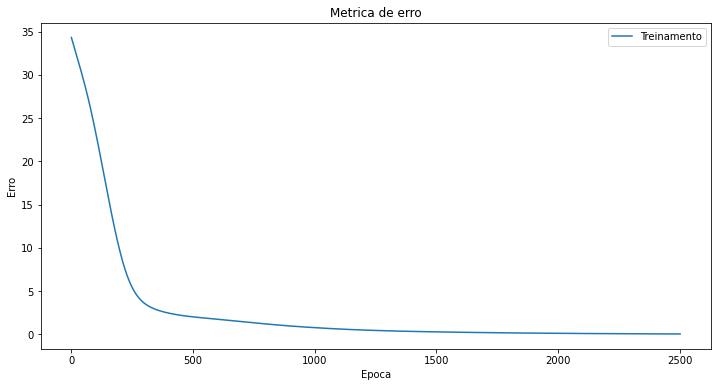

In [123]:
plt.figure(figsize=(12,6))
plt.plot(regr.loss_curve_)
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()


#### Keras

In [136]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(1)))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

# Compilar o modelo
model.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer='sgd')

print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 20)                40        
                                                                 
 dense_69 (Dense)            (None, 20)                420       
                                                                 
 dense_70 (Dense)            (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
None


In [137]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
3/3 [==============================] - 0s 52ms/step - loss: 60.9135 - mean_squared_error: 60.9135 - val_loss: 77.0049 - val_mean_squared_error: 77.0049
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 51.5246 - mean_squared_error: 51.5246 - val_loss: 62.0985 - val_mean_squared_error: 62.0985
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 39.4352 - mean_squared_error: 39.4352 - val_loss: 33.2606 - val_mean_squared_error: 33.2606
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 18.9387 - mean_squared_error: 18.9387 - val_loss: 18.2582 - val_mean_squared_error: 18.2582
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 10.2821 - mean_squared_error: 10.2821 - val_loss: 8.2413 - val_mean_squared_error: 8.2413
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 5.1974 - mean_squared_error: 5.1974 - val_loss: 7.6812 - val_mean_squared_error: 7.6812
Epoch 7/100
3/3 [=====

Epoch 52/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2605 - mean_squared_error: 0.2605 - val_loss: 0.6267 - val_mean_squared_error: 0.6267
Epoch 53/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 1.6316 - val_mean_squared_error: 1.6316
Epoch 54/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6341 - mean_squared_error: 0.6341 - val_loss: 0.8973 - val_mean_squared_error: 0.8973
Epoch 55/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2969 - mean_squared_error: 0.2969 - val_loss: 0.5184 - val_mean_squared_error: 0.5184
Epoch 56/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2312 - mean_squared_error: 0.2312 - val_loss: 0.6633 - val_mean_squared_error: 0.6633
Epoch 57/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2306 - mean_squared_error: 0.2306 - val_loss: 0.4933 - val_mean_squared_error: 0.4933
Epoch 58/100
3/3 [================

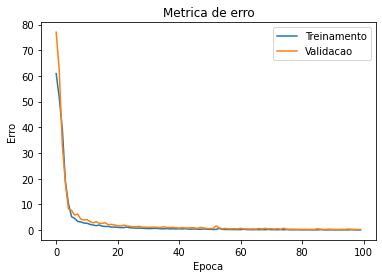

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()


### Rede Neural Implementada

In [75]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=output_dim, activation=linear))

nn.fit(X_train,y_train, X_test, y_test, True, epochs=3000, verbose=300)


epoch:    0/3000 loss_train: 33.03461963
epoch:  300/3000 loss_train: 0.31522372
epoch:  600/3000 loss_train: 0.17227372
epoch:  900/3000 loss_train: 0.10431172
epoch: 1200/3000 loss_train: 0.07405874
epoch: 1500/3000 loss_train: 0.05809366
epoch: 1800/3000 loss_train: 0.04746717
epoch: 2100/3000 loss_train: 0.04024903
epoch: 2400/3000 loss_train: 0.03504072
epoch: 2700/3000 loss_train: 0.03063862
epoch: 3000/3000 loss_train: 0.02732682


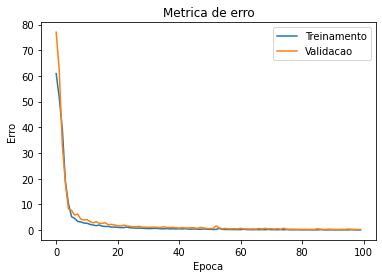

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()


epoch:    0/3000 loss_train: 51.98493660
epoch:  300/3000 loss_train: 0.58107121
epoch:  600/3000 loss_train: 0.29992889
epoch:  900/3000 loss_train: 0.18084072
epoch: 1200/3000 loss_train: 0.12280268
epoch: 1500/3000 loss_train: 0.09426826
epoch: 1800/3000 loss_train: 0.07852517
epoch: 2100/3000 loss_train: 0.06821779
epoch: 2400/3000 loss_train: 0.06048897
epoch: 2700/3000 loss_train: 0.05412978
epoch: 3000/3000 loss_train: 0.04879623


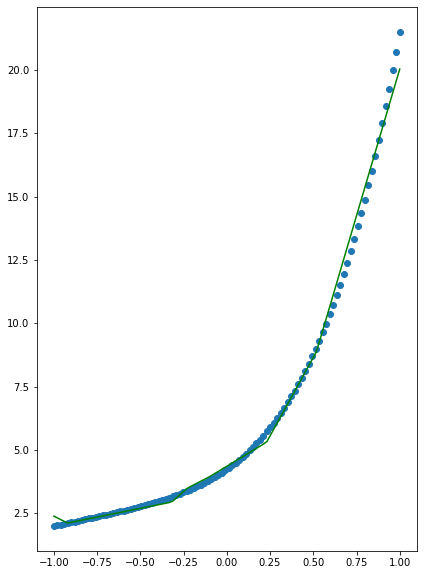

In [142]:
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=3000, verbose=300)


plt.figure(figsize = (15,10))
plt.subplot(1, 2, 1)
plt.scatter(x,y)
plt.plot(x, nn.predict(x), c="green")


### Questão 3

In [14]:
def Generate_data_problem(n_exemplos):
    x = np.random.uniform(-1,1,n_exemplos)
    y = np.random.uniform(-1,1,n_exemplos)
    
    dados = pd.DataFrame(data={'x':[0.1], 'y': [0.1], 'Class': [0]})
    
    
    for i in range(n_exemplos):
        if ( y[i] <= 1 - x[i] and x[i] >= 0 and y[i] >= 0 ):
            dados.loc[len(dados)] = [x[i],y[i],0]
            
        elif ( y[i] <= x[i] + 1 and x[i] <= 0 and y[i]>=0 ):
            dados.loc[len(dados)] = [x[i],y[i],1]
            
        elif ( y[i] >= -x[i] - 1 and x[i] <= 0 and y[i] <= 0 ):
            dados.loc[len(dados)] = [x[i],y[i],2]
            
        elif ( y[i] >= x[i] - 1 and x[i] >= 0 and y[i] <= 0 ):
            dados.loc[len(dados)] = [x[i],y[i],3]
            
        elif ( y[i] >= 1 - x[i] and x[i] >= 0 and y[i] >= 0  and x[i]**2 + y[i]**2 <=1 ):
            dados.loc[len(dados)] = [x[i],y[i],4]
            
        elif ( y[i] >= x[i] + 1 and x[i] <= 0 and y[i]>=0 and x[i]**2 + y[i]**2 <=1 ):
            dados.loc[len(dados)] = [x[i],y[i],5]
            
        elif ( y[i] <= -x[i] - 1 and x[i] <= 0 and y[i] <= 0 and x[i]**2 + y[i]**2 <=1 ):
            dados.loc[len(dados)] = [x[i],y[i],6]
            
        elif ( y[i] <= x[i] - 1 and x[i] >= 0 and y[i] <= 0 and x[i]**2 + y[i]**2 <=1 ):
            dados.loc[len(dados)] = [x[i],y[i],7]
            
            
    return dados

In [15]:
dados_gerados = Generate_data_problem(5000)

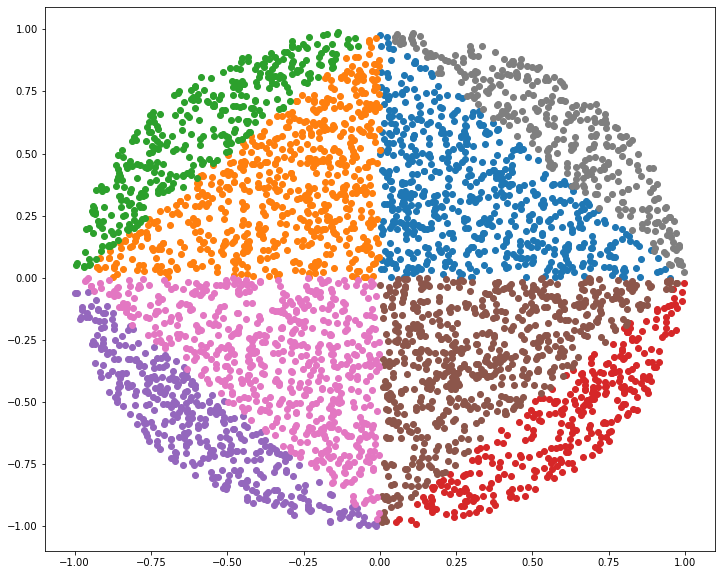

In [18]:
classes = dados_gerados['Class'].unique()
    
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

for classe in classes:
    valores = dados_gerados[dados_gerados['Class'] == classe].values
    x,y = valores[:,0] , valores[:,1]
    ax.scatter(x,y, label=classe)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dados_gerados[['x','y']].values,dados_gerados[['Class']].values, test_size=0.3)


dados_gerados[['x','y']].shape, dados_gerados[['Class']].shape # mostrando a quantidade de dados utilizados.

((3873, 2), (3873, 1))

In [164]:
one = OneHotEncoder(sparse=False)

y_train = one.fit_transform(y_train.reshape(-1,1))
y_train


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

### Perceptron regra delta sem momentum

In [172]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor( max_iter=3000).fit(X_train, y_train)

y_pred = regr.predict(X_test)
one.inverse_transform(y_pred)
pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test,pred))
print('Matriz de Confusão: \n')
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       168
         1.0       0.96      0.92      0.94       170
         2.0       0.92      0.97      0.94       192
         3.0       0.94      0.98      0.96       202
         4.0       1.00      0.93      0.97       106
         5.0       0.96      0.95      0.95       116
         6.0       0.94      0.91      0.93       115
         7.0       0.99      0.91      0.95       104

    accuracy                           0.95      1173
   macro avg       0.95      0.94      0.95      1173
weighted avg       0.95      0.95      0.95      1173

Matriz de Confusão: 

[[163   1   0   4   0   0   0   0]
 [  3 157   5   0   0   5   0   0]
 [  0   0 186   0   0   0   6   0]
 [  0   0   2 198   0   0   1   1]
 [  7   0   0   0  99   0   0   0]
 [  0   6   0   0   0 110   0   0]
 [  0   0  10   0   0   0 105   0]
 [  0   0   0   9   0   0   0  95]]


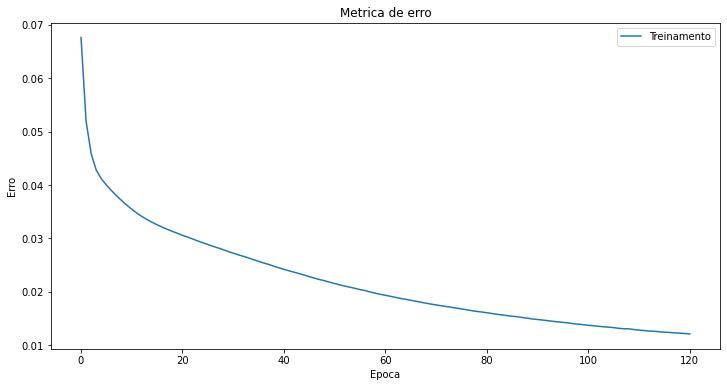

In [166]:
plt.figure(figsize=(12,6))
plt.plot(regr.loss_curve_)
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

### Perceptron regra delta com momentum

In [183]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor( max_iter=3000, momentum=0.52).fit(X_train, y_train)

y_pred = regr.predict(X_test)
one.inverse_transform(y_pred)
pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test,pred))
print('Matriz de Confusão: \n')
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       168
         1.0       0.97      0.92      0.95       170
         2.0       0.92      0.97      0.94       192
         3.0       0.98      0.98      0.98       202
         4.0       1.00      0.93      0.97       106
         5.0       0.94      0.97      0.96       116
         6.0       0.95      0.90      0.93       115
         7.0       0.99      0.96      0.98       104

    accuracy                           0.96      1173
   macro avg       0.96      0.95      0.96      1173
weighted avg       0.96      0.96      0.96      1173

Matriz de Confusão: 

[[166   1   0   1   0   0   0   0]
 [  1 157   5   0   0   7   0   0]
 [  0   1 187   0   0   0   4   0]
 [  2   0   1 197   0   0   1   1]
 [  7   0   0   0  99   0   0   0]
 [  0   3   0   0   0 113   0   0]
 [  0   0  11   0   0   0 104   0]
 [  0   0   0   4   0   0   0 100]]


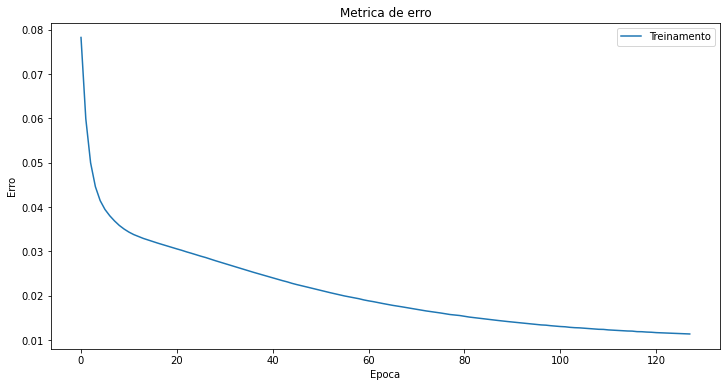

In [185]:
plt.figure(figsize=(12,6))
plt.plot(regr.loss_curve_)
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

### Rede Neural implementada

In [155]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)

nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation= tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation= relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation= linear))

nn.fit(X_train,y_train, epochs=3000, verbose=300)

y_pred = nn.predict(X_test)

epoch:    0/3000 loss_train: 2.71492165
epoch:  300/3000 loss_train: 1.28480495
epoch:  600/3000 loss_train: 0.91196014
epoch:  900/3000 loss_train: 0.72797964
epoch: 1200/3000 loss_train: 0.49095138
epoch: 1500/3000 loss_train: 0.40858242
epoch: 1800/3000 loss_train: 0.35492071
epoch: 2100/3000 loss_train: 0.31608371
epoch: 2400/3000 loss_train: 0.28630255
epoch: 2700/3000 loss_train: 0.26374720
epoch: 3000/3000 loss_train: 0.24488765


In [156]:
one.inverse_transform(y_pred)

array([[3.],
       [1.],
       [4.],
       ...,
       [2.],
       [0.],
       [2.]])

In [157]:
pred = np.argmax(y_pred, axis=1)


print(classification_report(y_test,pred))

print('Matriz de Confusão: \n')
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       192
         1.0       0.95      0.89      0.92       182
         2.0       0.91      0.90      0.90       175
         3.0       0.92      0.94      0.93       188
         4.0       0.91      0.89      0.90       121
         5.0       0.91      0.99      0.95       106
         6.0       0.90      0.94      0.92       109
         7.0       0.90      0.90      0.90       110

    accuracy                           0.92      1183
   macro avg       0.92      0.92      0.92      1183
weighted avg       0.92      0.92      0.92      1183

Matriz de Confusão: 

[[177   0   0   4  11   0   0   0]
 [  0 162  10   0   0  10   0   0]
 [  0   7 157   0   0   0  11   0]
 [  1   0   0 176   0   0   0  11]
 [ 13   0   0   0 108   0   0   0]
 [  0   1   0   0   0 105   0   0]
 [  0   0   6   0   0   0 103   0]
 [  0   0   0  11   0   0   0  99]]


In [158]:
y_pred = nn.predict(X_test[0])
np.argmax(y_pred)

3

In [159]:
X_test[0]

array([ 0.00475543, -0.43049409])

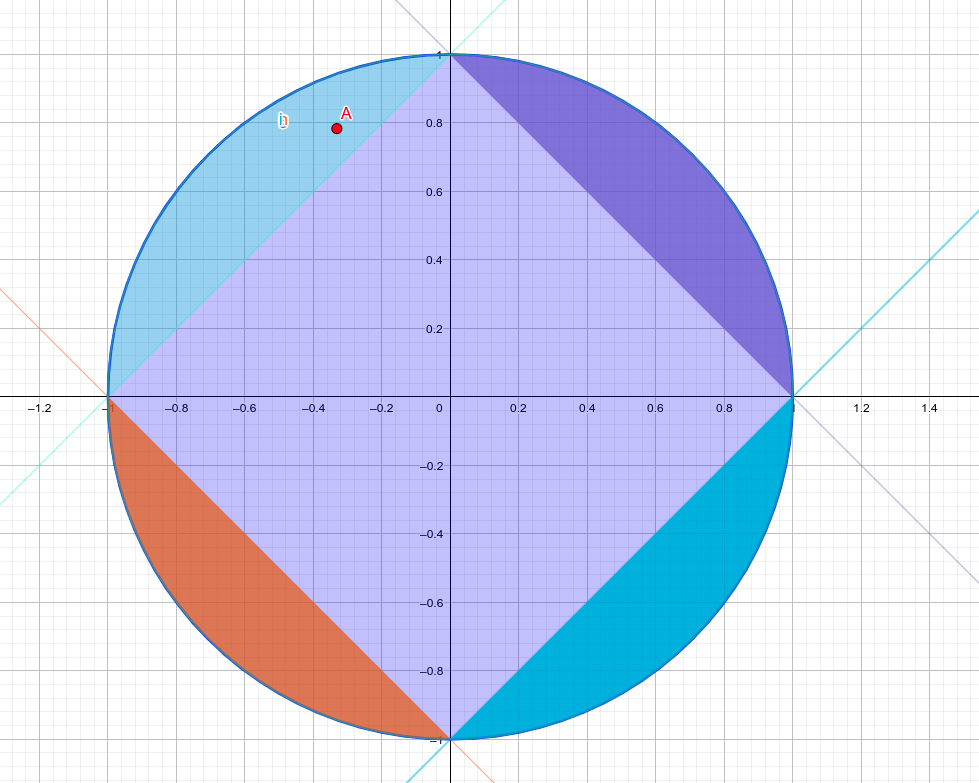

### Questão 4

In [77]:
x = np.arange(0,100)
# x = np.linspace(0,100,101)
y = np.sin(x)**2 + np.cos(x + np.cos(x))
data = pd.DataFrame(y, index=x, columns=["f(x)"])

<AxesSubplot:>

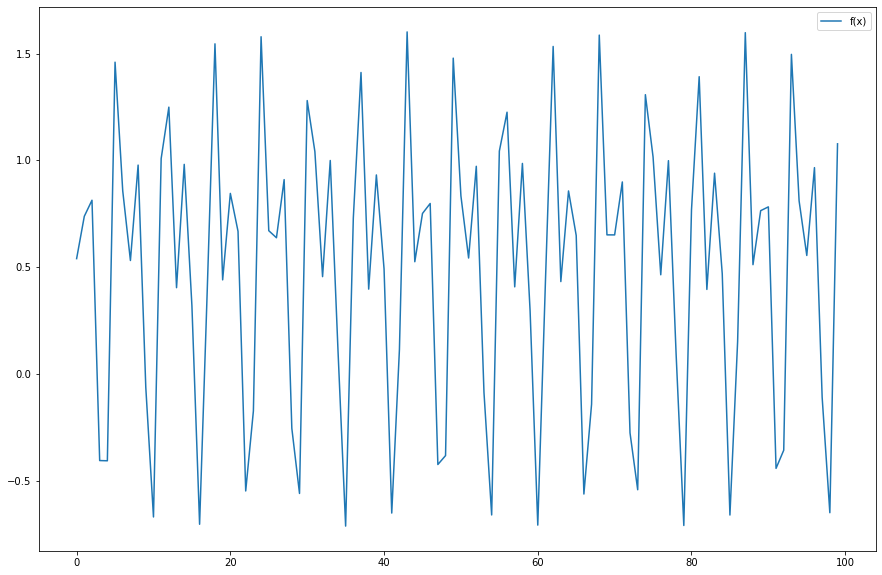

In [78]:
data.plot(figsize=(15,10))


In [79]:
def generate_Ts(data,tempo):
    novo_data = pd.DataFrame()
    novo_data['x'] = data # adicionando a primeira coluna 
    for i in range(1, tempo+1):
        novo_data[f'x-{i}'] = data.shift(i) # coloca para cada nova coluna x-n e adiciona pra esse cara os dados
    novo_data = novo_data.iloc[tempo:] # adiciona a mais do tempo passado
    return novo_data
    
    
def f(x):
    return np.sin(x)**2 + np.cos(x + np.cos(x))

In [80]:
time = 12
novo_data = generate_Ts(data['f(x)'],time)
novo_data

,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,x-10,x-11,x-12
12,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765,0.738563,0.540302
13,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765,0.738563
14,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765
15,0.319912,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311
16,-0.703644,0.319912,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392,0.469849,0.940395
96,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392,0.469849
97,-0.109378,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392
98,-0.649542,-0.109378,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278


In [81]:
# pegando apenas 3 colunas para classificação do y
X = novo_data[['x','x-1','x-2','x-3','x-4','x-5','x-6','x-7','x-8','x-9']].values
y = novo_data[['x-10','x-11','x-12']].values

X_train, y_train = X[:int(len(X)/2)],y[:int(len(y)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(y)/2):] 

#### usando um regressor de multiplas camadas do sklearn -> MLPRegressor

In [82]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred = regr.predict(X_test)
regr.score(X_test, y_test)

0.995566093516172

### Para os plots to utilizando todos os dados para tentar prever e ver a acuracia das colunas
- ele começa a prever depois dos 3 primeiros caras se mostra como seria a predição pra os 3 valores dos proximos valores

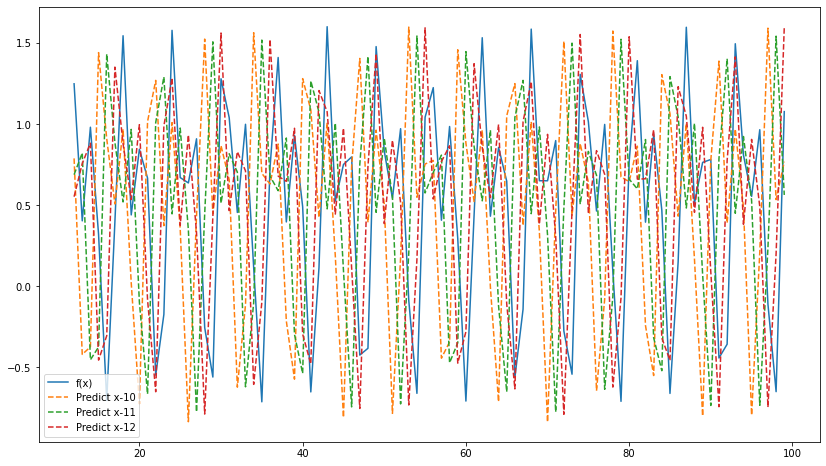

In [85]:
figure = plt.figure(figsize=(14,8))
axis = figure.add_subplot(111)

axis.plot(x[12:],f(x[12:]), label='f(x)')
axis.plot(x[12:], regr.predict(X)[:,0], '--',label='Predict x-10' )
axis.plot(x[12:], regr.predict(X)[:,1], '--',label='Predict x-11' )
axis.plot(x[12:], regr.predict(X)[:,2], '--',label='Predict x-12' )
axis.legend(loc='best')

#### previsão com apenas uma reta para melhor visualização, so mostrando o valor que esta determinada reta ta prevendo de acordo com os dados, por isso ela inicia so apois ter alguns valores anteriores

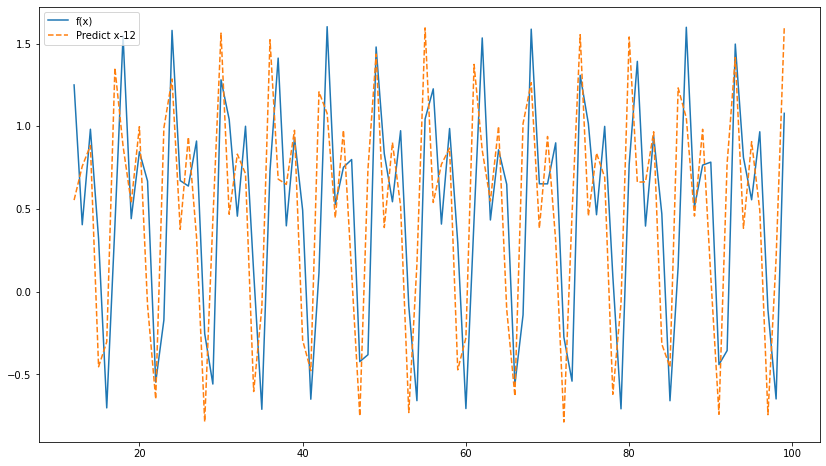

In [86]:
figure = plt.figure(figsize=(14,8))
axis = figure.add_subplot(111)

axis.plot(x[12:],f(x[12:]), label='f(x)')
axis.plot(x[12:], regr.predict(X)[:,2], '--',label='Predict x-12' )
axis.legend(loc='best')

In [88]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

nn = NeuralNetwork(learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=sigmoid))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=sigmoid))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(X_train,y_train, epochs=3000, verbose=300)

y_pred = nn.predict(X)

epoch:    0/3000 loss_train: 1.01306057
epoch:  300/3000 loss_train: 0.00734287
epoch:  600/3000 loss_train: 0.00316395
epoch:  900/3000 loss_train: 0.00195232
epoch: 1200/3000 loss_train: 0.00129966
epoch: 1500/3000 loss_train: 0.00092624
epoch: 1800/3000 loss_train: 0.00070197
epoch: 2100/3000 loss_train: 0.00056000
epoch: 2400/3000 loss_train: 0.00046522
epoch: 2700/3000 loss_train: 0.00039868
epoch: 3000/3000 loss_train: 0.00034982


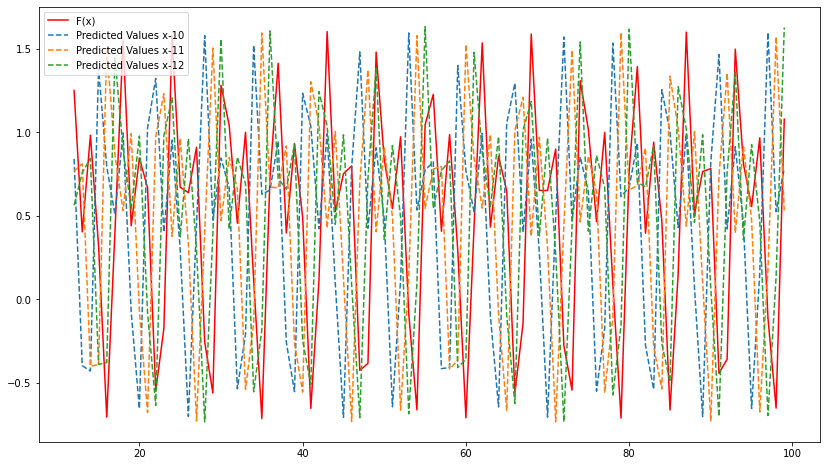

In [89]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.plot(x[12:],f(x[12:]),color='red', label='F(x)')
ax.plot(x[12:], y_pred[:,0], '--',label='Predicted Values x-10' )
ax.plot(x[12:], y_pred[:,1], '--',label='Predicted Values x-11' )
ax.plot(x[12:], y_pred[:,2], '--',label='Predicted Values x-12' )
ax.legend(loc='best')

#### Comparação de modelos 

In [49]:
def comparador(k):
    f0_to_tk = np.array([[f(i) for i in range(k)]])
    print('~'*32)
    print('MLP Regressor')
    print(regr.predict(f0_to_tk))
    print('~'*32)
    print('rede neural implementada')
    print(nn.predict(f0_to_tk))
    print('~'*32)
    print('valores da função')
    print(f(k), f(k+1), f(k+2))
    
#f(0) ate f(9)
comparador(10)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MLP Regressor
[[-0.60905344  0.52092056  1.07903034]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rede neural implementada
[[-0.42861691  0.9999517   1.25643438]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
valores da função
-0.6694342222603569 1.0088317080406155 1.2496583824586474
